# Purpose
This notebook contains sample code to evaluate calibration of a laser for optimal ion response.

# Summary
The code is organized to support modularity between the ion response behaviour and the calibration mechanism; each having their own abstract base class. Different implementation of these can be used to model different ion responses, and different algorithms to find optimal positions. The test code is generic to the base class allowing high reuse between test, and an easy path to switch between models and scan algorithms.

I decided to spend less time looking at the curve fitting/regression/optimization because this is highly dependent on the ion response and measurement capability. Instead I wanted to make it easy to update and change the code to enable a person to beable to quickly change implementation (implement a new base class).

I would recommend jumping down to the "Visualization of a Single Scan" section first to see the overall results. Then if you are interested you can browse the code to see what I have done.

## Know Issues

1. There have to be at least 13 positions per scan for the gaussian fit to work correctly.

# Details

## Ion Response

These classes determine what response is producted for the current mirror position.

1. mirror mount positions go from 0 to 1 (or any arbitrary continuous range really)
2. ion responses go from 0 to 100 photons per measurement round (or any arbitrary , small,
integer range)

I created an ideal (but quantized) gaussian response. This is easy to fit and work with.

## Calibration/Scan

These classes control what positions to try next via an iterator and how to determine the best position.

I implemented a linear scan that uses a fixed number of points. It picks the best position by fitting the gaussian curve and returnin the mean. It uses a [non-linear least square fit](https://en.wikipedia.org/wiki/Non-linear_least_squares) implimented [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy-optimize-curve-fit) 

In [20]:
from typing import List, Dict, Iterator
from abc import ABC, abstractmethod
import math
from operator import itemgetter

import scipy.stats as stats
from scipy import optimize

import numpy
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

def gaussian(x: float, amplitude: float, mean: float, stddev: float) -> float:
    """
    Method to generate a gaussian curve.

    Used for fitting and generating curves.

    """
    return amplitude * numpy.exp(-((x - mean) / 4 / stddev)**2)

class IonSystem(ABC):
    """
    Abstract base class for an ion system.

    This controls what response is produced at the current mirror position.

    """
    _max_ion_response = 100

    @abstractmethod
    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        ...

    @abstractmethod
    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        ...

class GaussianIonSystem(IonSystem):
    """
    Ion System that follows an ideal gaussian curve.

    """
    def __init__(self, peak_location: float, variance: float):
        self.peak_location: float = peak_location
        self.variance: float = variance
        self.pos: float = 0.

    @property
    def sigma(self) -> float:
        return math.sqrt(self.variance)

    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        self.pos = pos

    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        return round(
            gaussian(self.pos, self._max_ion_response, self.peak_location, self.sigma)
            )

class MeasureControlSystem(ABC):
    """
    Base class to define the positions to measure and how to pick the best postion.
    
    """

    # keep track of what was measured and recorded.
    _previous_positions: List[float]
    _previous_response: List[int]
    _step_index: int

    def __init__(self):
        self._initialize_search()

    def _initialize_search(self) -> None:
        """
        Initialize all the iterator parameters.

        """
        self._previous_positions = []
        self._previous_response = []
        self._step_index = 0

    @abstractmethod
    def pick_best_position(self) -> float:
        """
        return the best position based off the points collected.

        """
        ...

    @property
    @abstractmethod
    def search_complete(self) -> bool:
        """
        Return true when search is complete.

        """
        ...

    def next_position(self) -> float:
        """
        Private next postiion that also records the point.

        """
        cur_pos = self._next_position()
        self._previous_positions.append(cur_pos)
        self._step_index += 1
        return cur_pos

    @abstractmethod
    def _next_position(self) -> float:
        """
        Iterator to produce points.

        """
        ...

    def record_response(self, response: float) -> None:
        """
        Record what the response was for the previous points.

        Points must be recorded in the order measured.
        
        """
        self._previous_response.append(response)

    def __iter__(self) -> Iterator[float]:
        self._initialize_search()
        return self

    def __next__(self) -> float:
        if self.search_complete:
            raise StopIteration
        return self.next_position()
    
    def scan(self, ion_system: IonSystem) -> float:
        """
        Preform a scan of the given ion_system and return the position with ideal response.

        """
        for cur_position in self:
            ion_system.move_mirror_to_position(cur_position)
            self.record_response(ion_system.measure_ion_response())
   
        return self.pick_best_position()


class LinearSearchGaussianPicker(MeasureControlSystem):
    """
    Measure control system that does a linear search (scan) and picks the best position based off a gaussian fit.

    """

    def __init__(self, num_steps = 100):
        self.num_steps = num_steps
        self._positions = numpy.linspace(0,1,self.num_steps)

    def pick_best_position(self) -> float:
        """
        This picker assumes a gaussian curve, so we use a fit match to that.
        
        """
        ion_response_list = zip(self._previous_positions, self._previous_response)
        # Help the least square fit with a reasonable guess on the mean
        #   Sort the list to find the position with largest response.
        first_guess_mean = sorted(ion_response_list, key = itemgetter(1), reverse=True)[0][0]

        (_, mean, _), _ = optimize.curve_fit(gaussian, self._previous_positions, self._previous_response, p0=[100, first_guess_mean, 1])
        return mean

    @property
    def search_complete(self) -> bool:
        """
        Search is complete when all points have been iterated through.

        """
        return len(self._previous_positions) >= self.num_steps

    def _next_position(self) -> float:
        """
        Give the current index in our _positions list.

        """
        return self._positions[self._step_index]

## Test Code
The following methods evalute and visualize the calibration/scan process.

In [21]:
def evaluate_locator(
        cur_ion_sys: IonSystem, 
        measure_controller: MeasureControlSystem,
        expected_position: float,
        ) -> float:
    """
    Calculate the error between the expected and found optimal position.
    
    """
    scan_result = measure_controller.scan(cur_ion_sys)
    error = abs(scan_result - expected_position)
    return error

def plot_evaluation(
        cur_ion_sys: IonSystem, 
        measure_controller: MeasureControlSystem,
        expected_position: float,
        ) -> Figure:
    """
    Plot and return figure of an evaluation of a angle scan.

    """

    scan_result = measure_controller.scan(cur_ion_sys)
    error = abs(scan_result - expected_position)
    
    ion_responses: List[int] = []
    pos_scan = numpy.arange(0, 1, .0001)
    for pos in pos_scan:
        cur_ion_sys.move_mirror_to_position(pos)
        ion_response = cur_ion_sys.measure_ion_response()
        ion_responses.append(ion_response)

    fig, axes = plt.subplots(1,1)
    axes.plot(pos_scan, ion_responses, label="Measured Response")
    axes.axvline(scan_result, color='blue', label='Peak Detect')
    axes.axvline(expected_position, linestyle='dashed', color='gray', label='Peak Actual')
    axes.set_xlabel('Position')
    axes.set_ylabel('Ion Response')
    # dont use percent error because peak could be near zero.
    axes.set_title(f'Error: {error:.02e}')
    axes.legend()
    return fig


## Visualization of a Single Scan
The following cell visualizes a single scan. It shows the response, ideal response, and found optimal position. The plot also shows the error between the two.

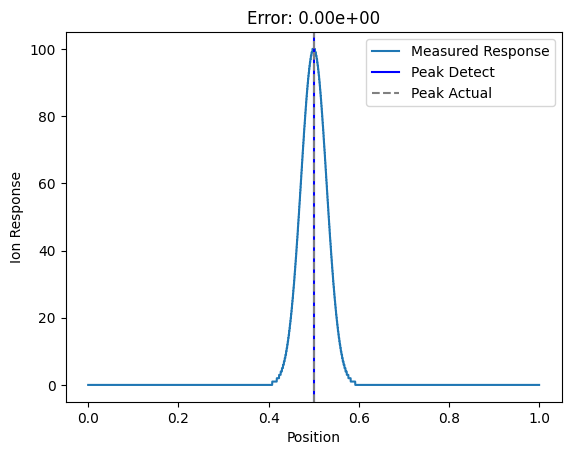

In [38]:
peak_location = .5
variance=.0001
num_scan_steps = 20
cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)
measure_controller = LinearSearchGaussianPicker(num_steps = num_scan_steps)

fig = plot_evaluation(
    cur_ion_sys=cur_ion_sys,
    measure_controller=measure_controller,
    expected_position=peak_location,
    )
fig.show()

## Visualization of The Error Of a Series Of Scans
The following cell visualizes the error of a series of scans across some parameter. In this case only the gaussian curve peak was varied. 

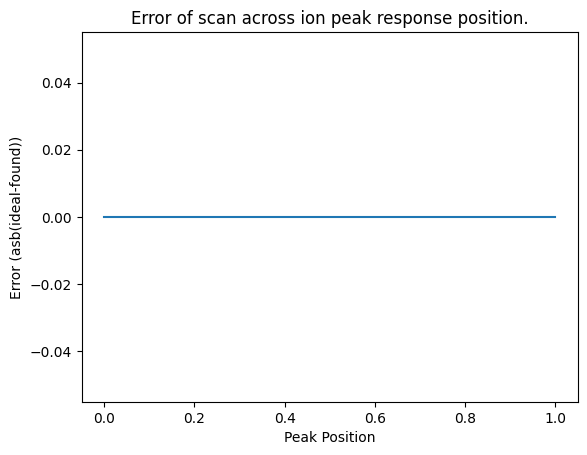

In [41]:
peak_locations = numpy.arange(0, 1, .001)
error: List[float] = []
num_scan_steps = 20

measure_controller = LinearSearchGaussianPicker(num_steps = num_scan_steps)

for cur_peak_location in peak_locations:
    variance=.0001
    cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)

    error.append(evaluate_locator(
        cur_ion_sys=cur_ion_sys,
        measure_controller=measure_controller,
        expected_position=peak_location,
        ))

fig, axes = plt.subplots(1,1)
axes.plot(peak_locations, error)
axes.set_xlabel('Peak Position')
axes.set_ylabel('Error (asb(ideal-found))')
axes.set_title('Error of scan across ion peak response position.')
fig.show()